In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import imageio
import imageio.v2 as imageio
import shutil
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import Image
from shutil import copy
from PIL import Image

In [ ]:
data_dir = '/content/drive/My Drive/UAS PCD_Nasir_Reza_Husni/butterfly/'
working_dir = '/content/drive/My Drive/UAS PCD_Nasir_Reza_Husni/butterflydescriptions'
model_dir = '/content/drive/My Drive/UAS PCD_Nasir_Reza_Husni/butterfly/segmentations'
image_dir = os.path.join(data_dir, "images")
segmentation_dir = os.path.join(data_dir, "segmentations")

In [ ]:
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
segmentation_files = [f for f in os.listdir(segmentation_dir) if os.path.isfile(os.path.join(segmentation_dir, f))]
labels = np.array([f[:3] for f in image_files]).astype('int32') - 1

image_files = [os.path.join(image_dir, f) for f in image_files]
segmentation_files = [os.path.join(segmentation_dir, f) for f in segmentation_files]

try:
    os.mkdir(model_dir)
except OSError as error:
    print("")

In [ ]:
def copy_files(filenames, dest_dir, labelname):
    label_dest_dir = os.path.join(dest_dir, str(label))

    if os.path.isdir(label_dest_dir):
        shutil.rmtree(label_dest_dir, ignore_errors=True)

    os.makedirs(label_dest_dir)


    [copy(file , label_dest_dir) for file in filenames]

    return

In [ ]:
def copy_images_and_masks(samples, masks, sample_dir, mask_dir, labels, current_label):
    sample_idx = np.where(labels == label)[0]
    sample_data = np.array(samples)[sample_idx]
    masks_data = np.array(masks)[sample_idx]

    copy_files(sample_data, sample_dir, label)
    copy_files(masks_data, mask_dir, label)

In [ ]:
image_segment_files = list(zip(image_files, segmentation_files))
X_train_seg, X_test_seg, y_train, y_test = train_test_split(image_segment_files, labels, train_size=0.8, random_state=5634)
X_train, X_train_segment = zip(*X_train_seg)
X_test, X_test_segment = zip(*X_test_seg)

unique_labels = np.unique(labels)
train_dest_dir = os.path.join(working_dir, "train")
train_segment_dest_dir = os.path.join(working_dir, "train_segment")
test_dest_dir = os.path.join(working_dir, "test")
test_segment_dest_dir = os.path.join(working_dir, "test_segment")

for label in unique_labels:
    copy_images_and_masks(X_train, X_train_segment, train_dest_dir, train_segment_dest_dir, y_train, label)
    copy_images_and_masks(X_test, X_test_segment, test_dest_dir, test_segment_dest_dir, y_test, label)

In [ ]:
def show_images_from_file(base_dir, label, num_images=25, num_per_row=5):
    image_dir = os.path.join(base_dir, str(label))

    files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    files = files[:num_images]

    images_per_row = min(num_images, num_per_row)
    n_rows = (num_images - 1) // images_per_row + 1

    row_images = []

    for row in range(n_rows):
        current_files = files[row * images_per_row : (row + 1) * images_per_row]
        images = [tf.image.resize(imageio.imread(file), [96, 96], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) for file in current_files]
        row_images.append(np.concatenate(images, axis=1))

    image = np.concatenate(row_images, axis=0)

    plt.figure(figsize = (images_per_row * 2, n_rows * 2))
    plt.imshow(image, interpolation='nearest')
    plt.axis("off")

    return

-----------------------------
Label: 0



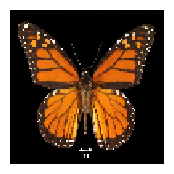

-----------------------------
Label: 1



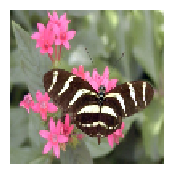

-----------------------------
Label: 2



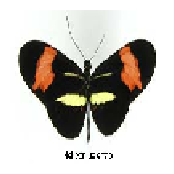

-----------------------------
Label: 3



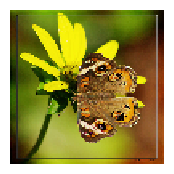

-----------------------------
Label: 4



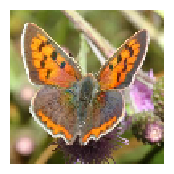

-----------------------------
Label: 5



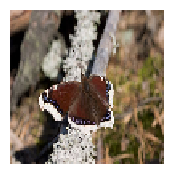

-----------------------------
Label: 6



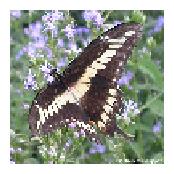

-----------------------------
Label: 7



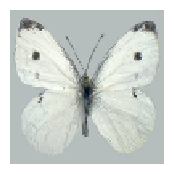

-----------------------------
Label: 8



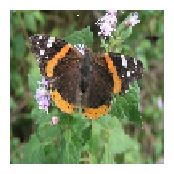

-----------------------------
Label: 9



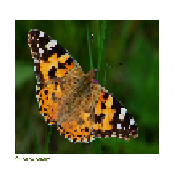

In [ ]:
for label in np.unique(labels):
    print("-----------------------------")
    print("Label: {}".format(label))
    print("")
    show_images_from_file(test_dest_dir, label, num_images=1)
    plt.show()

In [ ]:
show_images_from_file(train_dest_dir, 0)
show_images_from_file(train_dest_dir, 1)
show_images_from_file(test_dest_dir, 0, num_images=5)
show_images_from_file(test_dest_dir, 1, num_images=5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def create_data_generator(data_dir, batch_size, data_seed, target_size, args):
    datagen = ImageDataGenerator(**args)

    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=data_seed
    )

    return data_generator

In [ ]:
def create_sample_mask_generator(sample_dir, mask_dir, batch_size, data_seed, target_size, args):
    sample_datagen = create_data_generator(sample_dir, batch_size, data_seed, target_size, args)
    mask_datagen = create_data_generator(mask_dir, batch_size, data_seed, target_size, args)

    return [sample_datagen, mask_datagen]

In [ ]:
batch_size = 32
data_seed = 432
target_size = (92,92)

train_data_gen_args = dict(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_data_gen_args = dict(
    rescale=1./255
)

train_generator, train_mask_generator = create_sample_mask_generator(
    train_dest_dir,
    train_segment_dest_dir,
    batch_size,
    data_seed,
    target_size,
    train_data_gen_args
)

test_generator, test_mask_generator = create_sample_mask_generator(
    test_dest_dir,
    test_segment_dest_dir,
    batch_size,
    data_seed,
    target_size,
    test_data_gen_args
)

Found 665 images belonging to 10 classes.
Found 665 images belonging to 10 classes.
Found 167 images belonging to 10 classes.
Found 167 images belonging to 10 classes.


In [ ]:
image_shape = target_size + (3,)

model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=image_shape, name='conv_1'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='conv_3'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', name='dense_1'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='sigmoid', name='outputs')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size
)

<ipython-input-15-96a848470c25>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
20/20 [==============================] - 30s 896ms/step - loss: 2.3013 - accuracy: 0.1311 - val_loss: 2.2617 - val_accuracy: 0.2125
Epoch 2/50
20/20 [==============================] - 19s 982ms/step - loss: 2.2357 - accuracy: 0.1864 - val_loss: 2.0730 - val_accuracy: 0.1688
Epoch 3/50
20/20 [==============================] - 19s 972ms/step - loss: 2.0574 - accuracy: 0.2259 - val_loss: 1.7185 - val_accuracy: 0.3938
Epoch 4/50
20/20 [==============================] - 19s 986ms/step - loss: 1.7870 - accuracy: 0.3618 - val_loss: 1.5422 - val_accuracy: 0.4563
Epoch 5/50
20/20 [==============================] - 19s 908ms/step - loss: 1.7060 - accuracy: 0.3949 - val_loss: 1.4333 - val_accuracy: 0.5312
Epoch 6/50
20/20 [==============================] - 18s 922ms/step - loss: 1.5533 - accuracy: 0.4518 - val_loss: 1.2284 - val_accuracy: 0.5562
Epoch 7/50
20/20 [==============================] - 19s 973ms/step - loss: 1.4355 - accuracy: 0.4976 - val_loss: 1.1833 - val_accuracy: 0.5813

In [ ]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_filename = os.path.join(model_dir, "model_no_mask_{}.h5".format(timestamp))

print("Saving model in file {}".format(model_filename))
model.save(model_filename)

Saving model in file /content/drive/My Drive/UAS PCD_Nasir_Reza_Husni/butterfly/segmentations/model_no_mask_20230702-114049.h5


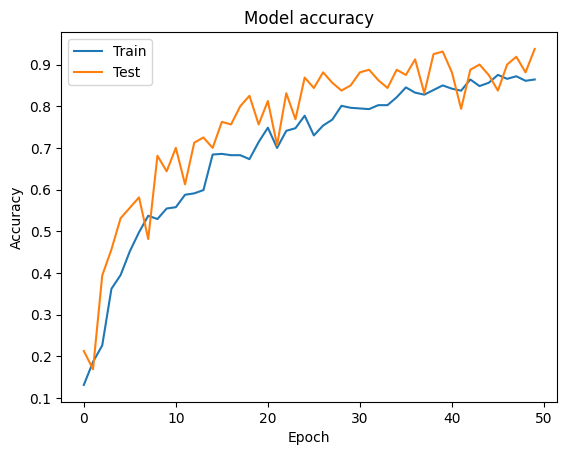

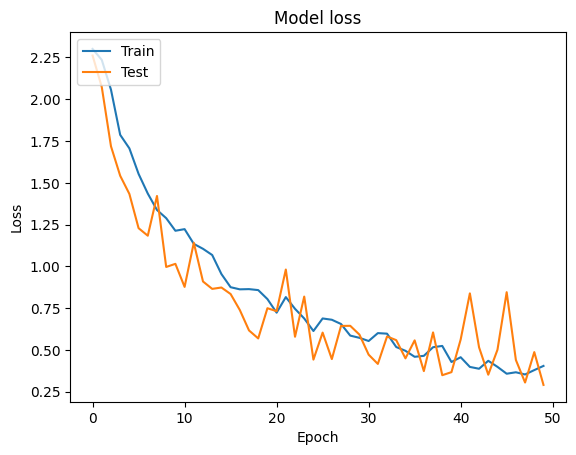

In [ ]:
history = model.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_filename = os.path.join(model_dir, "model_no_mask_{}.h5".format(timestamp))

early_stop = EarlyStopping(monitor='loss', mode='min', patience=50)
model_checkpoint = ModelCheckpoint(model_filename, monitor='val_accuracy', mode='max', save_best_only=True)

model_enhanced = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_normal', bias_initializer='random_uniform', activation='relu', input_shape=image_shape, name='conv_1'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_normal', bias_initializer='random_uniform', activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', bias_initializer='random_uniform', activation='relu', name='conv_3'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', bias_initializer='random_uniform', activation='relu', name='conv_4'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', bias_initializer='random_uniform', activation='relu', name='conv_5'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', bias_initializer='random_uniform', activation='relu', name='conv_6'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, kernel_initializer='he_normal', activation='relu', name='dense_1', use_bias=False),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, bias_initializer='random_uniform', activation='sigmoid', name='outputs')
])

model_enhanced.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())

model_enhanced.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=1000,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size,
    callbacks=[
        early_stop,
        model_checkpoint
    ]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 90, 90, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 43, 43, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 conv_3 (Conv2D)             (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 64)         0

<ipython-input-18-031393b2eb7b>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_enhanced.fit_generator(


Epoch 1/1000
20/20 [==============================] - 24s 912ms/step - loss: 2.5982 - accuracy: 0.1672 - val_loss: 16.6411 - val_accuracy: 0.0562
Epoch 2/1000
20/20 [==============================] - 20s 1s/step - loss: 2.1250 - accuracy: 0.2449 - val_loss: 4.4104 - val_accuracy: 0.1063
Epoch 3/1000
20/20 [==============================] - 19s 957ms/step - loss: 1.8206 - accuracy: 0.3476 - val_loss: 2.2185 - val_accuracy: 0.3063
Epoch 4/1000
20/20 [==============================] - 17s 872ms/step - loss: 1.6611 - accuracy: 0.4123 - val_loss: 2.9724 - val_accuracy: 0.2562
Epoch 5/1000
20/20 [==============================] - 20s 999ms/step - loss: 1.5133 - accuracy: 0.4581 - val_loss: 2.1524 - val_accuracy: 0.3125
Epoch 6/1000
20/20 [==============================] - 20s 1s/step - loss: 1.4786 - accuracy: 0.4597 - val_loss: 1.7147 - val_accuracy: 0.4437
Epoch 7/1000
20/20 [==============================] - 19s 963ms/step - loss: 1.2294 - accuracy: 0.5656 - val_loss: 2.2402 - val_accurac

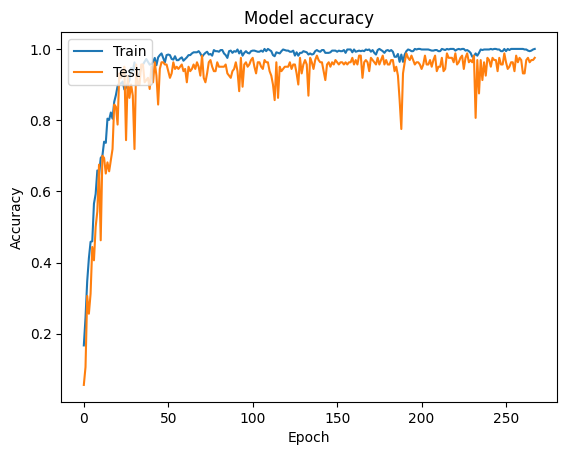

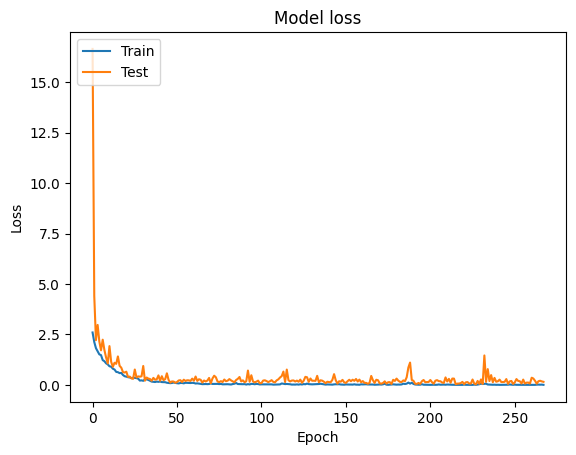

In [19]:
history = model_enhanced.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()